In [221]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD


In [222]:
# config
batch_size = 128
epochs = 20
reg = 0.0001
# reg = 0

# load data
A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")

# create mask variables, so we know which entries are not missing
# we use gt 0 condition since all of our ratings are between 0.5 and 5.0
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

# make copies since we will shuffle
# because each user occupying the same row in the train and test matrices, and each row index is actually a user_id
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()
A_pred_copy = A_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
# mu = sum of all the ratings devided by (the number of the ratings = sum of each entry in the mask, since it contains only zeros and ones)
mu = A.sum() / mask.sum()
print("mu:", mu)

N: 943 M: 1682
N // batch_size: 7
mu: 3.53005


In [223]:
# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))

# we wanna add some noise to the input(make some ratings zero), it will help model to learn better
x = Dropout(0.7)(i)

# even though we use dropout regularization, l2 regularization also helps
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)

x = Dense(M, kernel_regularizer=l2(reg))(x)


In [224]:

# we can't use keras's mse anymore! because it's going to count the delta at every output node, 
# even the ones were the ratings unknown so it's going to pull those outputs down to zero, 
# even though that shouldn't be




def custom_loss(y_true, y_pred):

# create a mask, the reason why we don't use our existing mask is because the arguments into the 
# loss function must be the targets and then predictions
# make the mask by finding all the entries of y_true which are not 0.
# that returns a boolean array and then we have to cast it to an array of zeros and ones by using K.cast
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    
# calculate the delta
  diff = y_pred - y_true
    
# mask delta and calculate the squared differences
# so this ensures that any square difference that doesn't come from an actual rating has 0 contribution to the cost
  sqdiff = diff * diff * mask
    
# sum up all the differences = sum of squared error
  sse = K.sum(K.sum(sqdiff))
    
# n = number of ratings = sum of entries in the mask
  n = K.sum(K.sum(mask))
    
# returm mean squared error(mse)
  return sse / n


In [225]:

# for training
def generator(A, M):
  while True:

    # shuffle the data, since that should be done before each epoch
    A, M = shuffle(A, M)
    
    # number of batches is aproximately equal to the length of the data devided by batch size
    # but because it is integer it's always going to round down. so we add 1
    for i in range(A.shape[0] // batch_size + 1):

      # since we add 1, the last batch is always smaller than the other batches
      # so we define the upper limit to be the minimum of (i+1)*batch_size, and the actual length 
      # of the data. so we don't go out of bounds of the array
      upper = min((i+1)*batch_size, A.shape[0])
    
      # grab the current batch and it's corresponding mask
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
        
      # center the data. because mu is the global average rating, it's not exactly equal to an integer 
      # or an int point 5 and so there is no danger here to subtracting mu from the ratings and 
      # accidently setting some of them to 0.
      # since that would make them not contributing to the cost. 
      # can not subtract mu from a. since if a contains 0 and you subtract mu from it,then you'll make 
      # the value -mu
      # so subtract the mu only from the entries that have an actual rating

      a = a - mu * m # must keep zeros at zero!
        
      # return the input and the targets
      yield a, a


In [226]:

# for testing
def test_generator(A_test, M_test):
  # assumes A_test is in corresponding order
  # of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      at = at - mu * mt
      yield at, at
    


In [227]:
# we are passing custom_loss function twice. because these actually yield two different results. 
# when keras is training, it reports the regularized loss, so it's gonna print that out
# so a loss you see is going to be a mse added to the L2 penalty, which is always bigger than just mse
# but when we pass in the function as a metric, it returns only the value from the loss you pass in
# so we will have 2 plots. one for the regularized mse and one for the pure mse
model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)

In [228]:
# takes the generator for the training data, and test generator for the validation data

r = model.fit_generator(
  generator(A, mask),
  validation_data=test_generator(A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())


Epoch 1/20
8/8 [==============================] - 1s 66ms/step - loss: 1.5986 - custom_loss: 1.3935 - val_loss: 1.4544 - val_custom_loss: 1.2483
Epoch 2/20
8/8 [==============================] - 0s 47ms/step - loss: 1.5144 - custom_loss: 1.3087 - val_loss: 1.3944 - val_custom_loss: 1.1889
Epoch 3/20
8/8 [==============================] - 0s 49ms/step - loss: 1.3936 - custom_loss: 1.1865 - val_loss: 1.3276 - val_custom_loss: 1.1227
Epoch 4/20
8/8 [==============================] - 0s 49ms/step - loss: 1.2883 - custom_loss: 1.0915 - val_loss: 1.2641 - val_custom_loss: 1.0599
Epoch 5/20
8/8 [==============================] - 0s 47ms/step - loss: 1.2018 - custom_loss: 0.9968 - val_loss: 1.2109 - val_custom_loss: 1.0071
Epoch 6/20
8/8 [==============================] - 0s 52ms/step - loss: 1.1359 - custom_loss: 0.9376 - val_loss: 1.1692 - val_custom_loss: 0.9659
Epoch 7/20
8/8 [==============================] - 0s 58ms/step - loss: 1.0719 - custom_loss: 0.8744 - val_loss: 1.1357 - val_custo

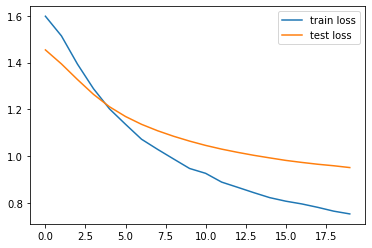

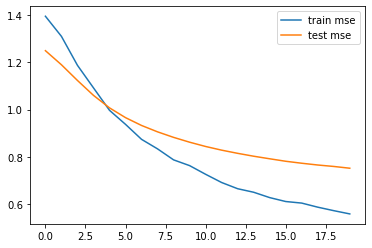

In [229]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

In [230]:
df = pd.read_csv('C:\\Users\\p\\Notebooks\\Collaborative Filtering\\edited_rating.csv')
df.head()

,userId,movieId,rating,movie_idx
0,195,242,3,241
1,185,302,3,301
2,21,377,1,376
3,243,51,2,50
4,165,346,1,345


In [231]:
movies = pd.read_csv('C:\\Users\\p\\Notebooks\\Collaborative Filtering\\Movielens_Titles.csv',encoding= 'unicode_escape')
movies.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [233]:
# user_ids in edited_ratings.csv file, starts from 0 ... N-1
my_user_id = 0
my_user_interaction = A_pred_copy[my_user_id].todense()

a = np.array(my_user_interaction).flatten()

# since the actual ratings are always between 0.5 to 5, rating 0 for a movie means that this user
# has not watched this movie yet
movies_not_watched = np.where(a == 0)[0]
movies_not_watched[:10]


array([ 0,  2,  4,  5,  6,  8,  9, 12, 13, 14], dtype=int64)

In [234]:
# predict the ratings for user
pred = model.predict(my_user_interaction).flatten()
pred

array([1.0256788 , 1.4918416 , 0.31297582, ..., 0.4498946 , 0.9152818 ,
       0.27727848], dtype=float32)

In [235]:
# predicted ratings for movies that user has not watched
predicted_movies_not_watched = np.array([pred[i] for i in movies_not_watched])
predicted_movies_not_watched

array([ 1.0256788 ,  0.31297582, -0.2730075 , ...,  0.4498946 ,
        0.9152818 ,  0.27727848], dtype=float32)

In [194]:
# create a tuple of predicted ratings and indices of movies
list_tuples = list(zip(movies_not_watched, predicted_movies_not_watched))

# sort this tuple in descending order
list_tuples = sorted(list_tuples, key=lambda x: x[1], reverse=True)
list_tuples[:10]

[(693, 2.1059258),
 (179, 1.8456361),
 (210, 1.7627332),
 (173, 1.732012),
 (611, 1.7192918),
 (97, 1.6773809),
 (600, 1.6619753),
 (662, 1.6452038),
 (432, 1.6380984),
 (45, 1.6293184)]

In [236]:
movie_indices_for_top_rating = list(list_tuples[i][0] for i in range (0,10))

# find the actual movieId 
for movie_index in movie_indices_for_top_rating:
    movie_index = df[df['movie_idx'] == movie_index]['movieId']

# find titles of top rating movie indices and print those titles
recommended_movies = movies[movies["item_id"].isin(movie_indices_for_top_rating)]
for row in recommended_movies.itertuples():
    print(row.title)

Eat Drink Man Woman (1994)
Dances with Wolves (1990)
Princess Bride, The (1987)
Clockwork Orange, A (1971)
Indiana Jones and the Last Crusade (1989)
Fantasia (1940)
Daniel Defoe's Robinson Crusoe (1996)
Laura (1944)
Somewhere in Time (1980)
Casino (1995)
